# Training a Vanilla Classifier with the MNIST dataset

In this notebook, I will be training both a CNN and an MLP to classify the MNIST problem. The main objective of both implementations is to study how to implement LRP algorithms for further understanding within our laboratory. 

This notebook was developed by Cesar Augusto Sanchez-Villalobos. @cesarasa in TTU and @CesarAugusto14 in GitHub. 

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.manifold import TSNE
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader, random_split

# Check the available devices (mps is to train on multiple GPUs, or in M1 Macs)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(device)

mps


## Loading the data:

The MNIST dataset is available in the `torchvision` library. We can load the dataset using the `torchvision.datasets.MNIST` class. The dataset contains images of size 28x28. We will normalize the images and convert them to tensors. Then, we will use the `DataLoader` class to create batches of data.

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]
# One hot encode the labels
# train_data.targets = one_hot_encode(train_data.targets, 10)
# test_data.targets = one_hot_encode(test_data.targets, 10)


# Split train into train and validation
train_data, val_data = random_split(train_data, [50000, 10000])

# Convert the labels into a one-hot encoded


# Data Loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)      # It is good practice to shuffle the training data as it helps the model to generalize better
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

## Model construction:

In [46]:
class MLP(nn.Module):
    """
    The following class defines a tunable MLP model. It will have: 
    
    n_layers : number of hidden layers in the network.
    n_units  : number of units in each hidden layer.
    n_inputs : number of input features.
    n_outputs: number of output features.
    """
    
    def __init__(self, n_layers : int,
                       n_units  : int,
                       n_inputs : int,
                       n_outputs: int):
        super(MLP, self).__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # Initialize the list of layers
        self.layers = nn.ModuleList()
        
        assert n_layers > 0, "Number of hidden layers must be greater than 0."
        
        # Add the first hidden layer
        self.layers.append(nn.Linear(n_inputs, n_units))
        
        # Add the remaining hidden layers
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(n_units, n_units))
            
        # Add the output layer
        self.layers.append(nn.Linear(n_units, n_outputs))
        
    def forward(self, x):
        """
        Forward pass of the network.
        """
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)
    
    def summary(self):
        """
        Print the summary of the network.
        """
        print(summary(self, (1, self.n_inputs)))
        
    def fit(self, train_loader : torch.utils.data.DataLoader,
            val_loader   : torch.utils.data.DataLoader,
            n_epochs     : int,
            lr           : float,
            criterion    : torch.nn.modules.loss,
            device       : torch.device):
        """
        Fit the model to the data.
        """
        # Send the model to the device
        self.to(device)
        
        # Initialize the optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        # Initialize the history dictionary
        history = {'train_loss': [], 'val_loss': []}
        
        # Train the model
        for epoch in range(n_epochs):
            train_loss = 0.0
            val_loss = 0.0
            
            # Train the model
            self.train()
            for x, y in train_loader:
                x, y = x.to(device), one_hot_encode(y, 10).to(device)
                optimizer.zero_grad()
                y_hat = self(x.view(x.size(0), -1))
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            history['train_loss'].append(train_loss / len(train_loader))
            
            # Validate the model
            self.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_hat = self(x.view(x.size(0), -1))
                    loss = criterion(y_hat, y)
                    val_loss += loss.item()
                history['val_loss'].append(val_loss / len(val_loader))
                
            # Print the progress
            print(f'Epoch {epoch + 1}/{n_epochs} | Train Loss: {history["train_loss"][-1]:.5f} | Val Loss: {history["val_loss"][-1]:.5f}')
            if epoch+1 == n_epochs:
                print('Finished Training')
                print('Final Train Loss: ', train_loss/len(train_loader))
        return history
        
    def predict(self, test_loader : torch.utils.data.DataLoader,
                device : torch.device):
        """
        Predict the labels of the test data.
        """
        self.eval()
        predictions = []
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                y_hat = self(x.view(x.size(0), -1))
                predictions.extend(y_hat.argmax(dim=1).cpu().numpy())
        return predictions
        
model = MLP(n_layers=1, n_units=5, n_inputs=28*28, n_outputs=10)

# Print the model summary
model.summary()

# Define the hyperparameters
n_epochs = 10
lr = 1e-3
criterion = nn.CrossEntropyLoss()

# Fit the model
history = model.fit(train_loader, val_loader, n_epochs, lr, criterion, device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 5]           3,925
            Linear-2                [-1, 1, 10]              60
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
None
Epoch 1/10 | Train Loss: 0.92188 | Val Loss: 0.55088
Epoch 2/10 | Train Loss: 0.48241 | Val Loss: 0.45516
Epoch 3/10 | Train Loss: 0.41868 | Val Loss: 0.42286
Epoch 4/10 | Train Loss: 0.39295 | Val Loss: 0.40840
Epoch 5/10 | Train Loss: 0.37814 | Val Loss: 0.39273
Epoch 6/10 | Train Loss: 0.36958 | Val Loss: 0.38754
Epoch 7/10 | Train Loss: 0.36380 | Val Loss: 0.38723
Epoch 8/10 | Train Loss: 0.35897 | Val Loss: 0.38510
E

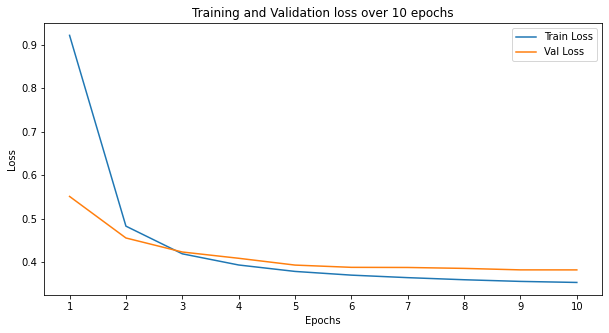

In [54]:
# Plot 
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11, 1), history['train_loss'], label='Train Loss')
plt.plot(np.arange(1, 11, 1), history['val_loss']  , label='Val Loss')
# The xticks go from 1 to 10
plt.xticks(np.arange(1, 11, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss over 10 epochs')
plt.show()